1. 데이터 로딩
2. 자료 정리
3. AE 모델 통하기
4. 머신러닝

In [1]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor,XGBClassifier # model
from xgboost import plot_importance # 중요변수 시각화
from sklearn.model_selection import train_test_split
import numpy as np

labeled = pd.read_csv('../datasets/labeled.csv')
unlabeled = pd.read_csv('../datasets/unlabeled.csv')

In [2]:
labeled_col = labeled.columns
unlabeled_col = unlabeled.columns
labeled_train = labeled.copy()
unlabeled_train = unlabeled.copy()

In [3]:
# 중복 항목 제거
labeled_train.drop_duplicates(['_id'], inplace=True)
labeled_train.drop(['EQUIP_CD' ],axis=1, inplace=True)
labeled_train.drop(['PART_FACT_PLAN_DATE' ],axis=1, inplace=True)
labeled_train.drop(['PassOrFail' ],axis=1, inplace=True)
unlabeled_train.drop_duplicates(['_id'], inplace=True)
unlabeled_train.drop(['EQUIP_CD' ],axis=1, inplace=True)
unlabeled_train.drop(['PART_FACT_PLAN_DATE' ],axis=1, inplace=True)
unlabeled_train.drop(['PART_NO' ],axis=1, inplace=True)
unlabeled_train.drop(['Unnamed: 0' ],axis=1, inplace=True)


In [4]:
label_len = labeled_train.shape[0]
unlabel_len = unlabeled_train.shape[0]
merged_data = pd.concat([labeled_train, unlabeled_train])
# merged_data_copy = merged_data.copy()
merged_data_copy = unlabeled_train.copy() # only unlabeled data

In [5]:
merged_data.columns

Index(['_id', 'TimeStamp', 'PART_FACT_SERIAL', 'PART_NAME', 'EQUIP_NAME',
       'Reason', 'Injection_Time', 'Filling_Time', 'Plasticizing_Time',
       'Cycle_Time', 'Clamp_Close_Time', 'Cushion_Position',
       'Switch_Over_Position', 'Plasticizing_Position', 'Clamp_Open_Position',
       'Max_Injection_Speed', 'Max_Screw_RPM', 'Average_Screw_RPM',
       'Max_Injection_Pressure', 'Max_Switch_Over_Pressure',
       'Max_Back_Pressure', 'Average_Back_Pressure', 'Barrel_Temperature_1',
       'Barrel_Temperature_2', 'Barrel_Temperature_3', 'Barrel_Temperature_4',
       'Barrel_Temperature_5', 'Barrel_Temperature_6', 'Barrel_Temperature_7',
       'Hopper_Temperature', 'Mold_Temperature_1', 'Mold_Temperature_2',
       'Mold_Temperature_3', 'Mold_Temperature_4', 'Mold_Temperature_5',
       'Mold_Temperature_6', 'Mold_Temperature_7', 'Mold_Temperature_8',
       'Mold_Temperature_9', 'Mold_Temperature_10', 'Mold_Temperature_11',
       'Mold_Temperature_12', 'ERR_FACT_QTY'],
      dty

In [6]:
summary_dict=dict()
for col in merged_data_copy.columns:
    if col == 'ERR_FACT_QTY': continue
    if merged_data_copy[col].dtype =='object':
        tmp = dict(merged_data_copy[col].value_counts())
        if len(tmp)>100:
            merged_data_copy.drop([col],axis=1, inplace=True)        
        else:
            output_features_info = dict()            
            cnt_features = len(tmp)
            eye_mat = np.eye(cnt_features)
            for idx, feature in enumerate(tmp.keys()):
                output_features_info[feature]=eye_mat[idx]
            summary_dict[col]=output_features_info
    elif 'Mold_Temperature' in col:
        if int(col.split('_')[-1]) > 4:
            merged_data_copy.drop([col],axis=1, inplace=True)
    else:
        merged_data_copy[col] = (merged_data_copy[col]-merged_data_copy[col].mean())/merged_data_copy[col].std()

In [7]:
summary_dict.keys()

dict_keys(['PART_NAME', 'EQUIP_NAME', 'Reason'])

In [8]:
merged_data_copy = merged_data_copy.fillna('None')

In [9]:
merged_data_copy['Reason'].value_counts()

None      800487
가스            35
미성형           15
초기허용불량        10
Name: Reason, dtype: int64

In [10]:
summary_dict['Reason']

{'None': array([1., 0., 0., 0.]),
 '가스': array([0., 1., 0., 0.]),
 '미성형': array([0., 0., 1., 0.]),
 '초기허용불량': array([0., 0., 0., 1.])}

In [11]:
def func_reason_label(x):
    try:
        return summary_dict[k][x]
    except Exception:
        return None
for k in summary_dict.keys():
    print(k)
    merged_data_copy[k+"_"]=merged_data_copy[k].apply(func_reason_label)
    merged_data_copy.drop([k],axis=1, inplace=True)

PART_NAME
EQUIP_NAME
Reason


In [12]:
part_name = merged_data_copy.pop('PART_NAME_')
equip_name = merged_data_copy.pop('EQUIP_NAME_')
# passorfail = labeled_train.pop('PassOrFail')
reason = merged_data_copy.pop('Reason_')
err_fact_qty = merged_data_copy.pop('ERR_FACT_QTY')

In [13]:
merged_data_copy_np = np.array(merged_data_copy)

In [14]:
merged_data_copy.shape, part_name.shape, equip_name.shape

((800547, 29), (800547,), (800547,))

In [15]:
datasets=list()
for dt, part, equip in zip(merged_data_copy_np, part_name, equip_name):    
    datasets.append(np.hstack([dt, part, equip]))

In [16]:
import pickle
with open('datasets.pickle', 'wb') as f:
    pickle.dump(datasets, f)

In [17]:
train_datasets = datasets[:label_len]
train_reason = reason[:label_len]
train_err_fact_qty = err_fact_qty[:label_len]
test_datasets = datasets[label_len:]
test_reason = reason[label_len:]
test_err_fact_qty = err_fact_qty[label_len:]

In [18]:
datasets_analysis = [train_datasets, train_reason, train_err_fact_qty, test_datasets, test_reason, test_err_fact_qty]
with open('datasets_analysis.pickle', "wb") as f:
    pickle.dump(datasets_analysis, f)

# AE Vector 생성

In [19]:
import torch
from torch import nn
class Discriminator(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.in_features = in_features
        self.out_classes = 30
        self.down = nn.Sequential(            
            self._block_down(self.in_features, self.in_features*2),           
            self._block_down(self.in_features*2, self.in_features*2),           
            self._block_down(self.in_features*2, self.in_features),           
            self._block_down(self.in_features, self.in_features//2),           
            self._block_down(self.in_features//2, self.in_features//4),           
            self._block_down(self.in_features//4, self.out_classes),                       
            # nn.Tanh()
        )
        self.up = nn.Sequential(
            self._block_down(self.out_classes,self.in_features//4),
            self._block_down(self.in_features//4,self.in_features//2),
            self._block_down(self.in_features//2,self.in_features),
            self._block_down(self.in_features,self.in_features*2),
            self._block_down(self.in_features*2,self.in_features*2),
            self._block_down(self.in_features*2,self.in_features*2),
            self._block_down(self.in_features*2,self.in_features),
            # nn.Tanh() # 여기만 다시 활성화       효과없음     
        )
        self.essens=None
    
    def _block_down(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Linear(in_channels,out_channels),
            nn.Mish(True),
            nn.Dropout(0.5)
        )
    def _block_up(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Linear(in_channels,out_channels),
            nn.Mish(True),
            nn.Dropout(0.5)
        )
    def forward(self, x):
        self.essens = self.down(x)
        x2 = self.up(self.essens)
        return x2
    def get_vector(self, x):
        self.essens = self.down(x)
        return self.essens

In [20]:
IN_FEATURES = datasets[0].shape[0]
critic = Discriminator(IN_FEATURES).eval()

In [21]:
BEST_MODEL_PATH = 'best_model_AE_1_2.pth'
critic.load_state_dict(torch.load(BEST_MODEL_PATH))
critic = critic.to('cuda')

In [22]:
# from tqdm.notebook import tqdm
# train set vector getter
train_vector=list()
for dt in train_datasets:    
    ret = critic.get_vector(torch.from_numpy(dt).float().to('cuda'))
    ret_ = ret.detach().cpu().numpy()
    train_vector.append(ret_)

In [23]:
# test set vector getter
test_vector=list()
for dt in test_datasets:
    ret = critic.get_vector(torch.from_numpy(dt).float().to('cuda'))
    ret_ = ret.detach().cpu().numpy()
    test_vector.append(ret_)

## XGBoost

In [24]:
train_reason_pre = list()
for y in train_reason:
    if y.argmax()==0:
        train_reason_pre.append(0)
    else:
        train_reason_pre.append(1)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(train_vector,train_reason_pre,test_size=0.2)

In [26]:
model_xg = XGBClassifier()

In [27]:
model_xg.fit(X_train, y_train)

/home/hans/VENV/torch/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:11:55] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=6,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

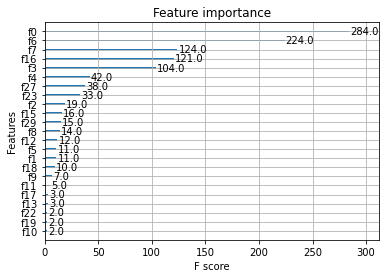

In [28]:
from xgboost import plot_importance # 중요변수 시각화
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
plot_importance(model_xg)

In [29]:
pred_y = model_xg.predict(X_test)

In [30]:
mean_squared_error(y_test,pred_y)

0.017191977077363897

In [31]:
np.sum(y_test==pred_y)/len(y_test)

0.9828080229226361

In [32]:
from sklearn.metrics import classification_report
print(classification_report(y_test,pred_y))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1032
           1       0.20      0.07      0.10        15

    accuracy                           0.98      1047
   macro avg       0.59      0.53      0.55      1047
weighted avg       0.98      0.98      0.98      1047



In [33]:
df = pd.DataFrame(y_test)

In [34]:
df.value_counts()

0    1032
1      15
dtype: int64

In [35]:
from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier(criterion='entropy')

In [36]:
model_rf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy')

In [37]:
pred_y = model_rf.predict(X_test)

In [38]:
mean_squared_error(y_test,pred_y)

0.015281757402101241

In [39]:
np.sum(y_test==pred_y)/len(y_test)

0.9847182425978988

In [40]:
print(classification_report(y_test,pred_y))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1032
           1       0.33      0.07      0.11        15

    accuracy                           0.98      1047
   macro avg       0.66      0.53      0.55      1047
weighted avg       0.98      0.98      0.98      1047



In [41]:
from lightgbm import LGBMClassifier

In [53]:
model_lgb = LGBMClassifier(boosting_type='goss')

In [54]:
model_lgb.fit(X_train, y_train)

LGBMClassifier(boosting_type='goss')

In [55]:
pred_y = model_lgb.predict(X_test)


In [56]:
mean_squared_error(y_test,pred_y)


0.02005730659025788

In [57]:
print(classification_report(y_test,pred_y))


              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1032
           1       0.00      0.00      0.00        15

    accuracy                           0.98      1047
   macro avg       0.49      0.50      0.49      1047
weighted avg       0.97      0.98      0.98      1047

